## Set up the Environment

In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'HSP_Multi_Class_Classifier_Using_Llama2_Fine_Tuned_Model_on_data_3.0-copy1.ipynb'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
!nvidia-smi

Sat May 25 05:19:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   30C    P0              45W / 300W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import wandb
wandb.init('19010c4e439d59bec411f7f9075c6e73ac7f5e13')    # Initialize wandb with your API key
wandb.login()   # Authenticate with wandb.ai

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find HSP_Multi_Class_Classifier_Using_Llama2_Fine_Tuned_Model_on_data_3.0-copy1.ipynb.
wandb: Currently logged in as: yadav-sunil531984 (hsp_bits). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Import Libraries

In [4]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification 
import evaluate
import numpy as np
from transformers import Trainer
from transformers import TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

2024-05-25 05:19:40.066699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 05:19:40.840455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data sets

Total Count of Samples =  4374


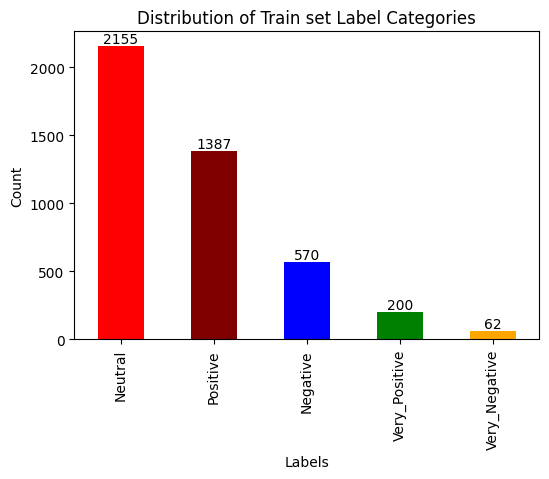

In [5]:
# Visualization of Class Labels Taining data
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(train_df))
label_counts = train_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


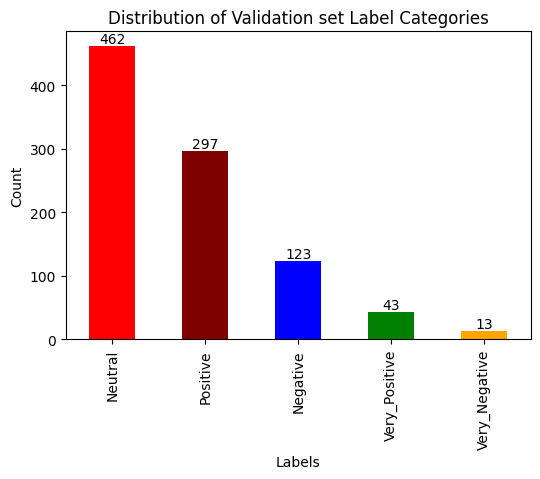

In [6]:
# Visualization of Class Labels Validation data
val_df = pd.read_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(val_df))
label_counts = val_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Validation set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


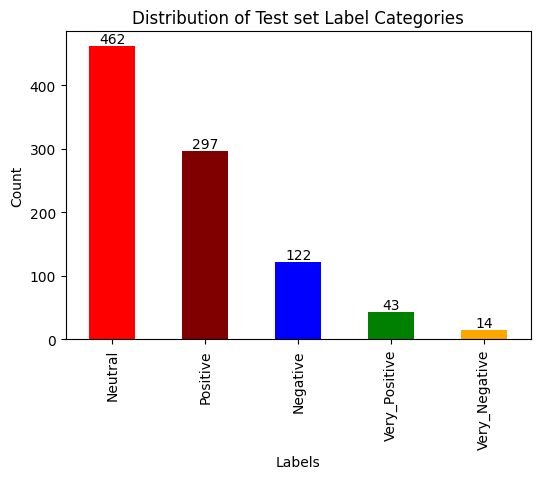

In [7]:
# Visualization of Class Labels Taining data
test_df=pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(test_df))
label_counts = test_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Test set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [8]:
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4374 entries, 0 to 4373
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4374 non-null   int64 
 1   Text       4374 non-null   object
 2   Label_Id   4374 non-null   int64 
 3   Label      4374 non-null   object
 4   Label_Rev  4374 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 171.0+ KB


In [9]:
unique_values = train_df['Label_Rev'].unique()
unique_values 

array([0, 2, 1, 3, 4])

## Number of Characters

In [10]:
# Number of Characters
import pandas as pd

# Load the training data from the CSV file
train_df = pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

# Calculate the maximum number of characters in the 'text' column
max_char = train_df['Text'].str.len().max()

# Calculate the maximum number of words in the 'text' column
max_words = train_df['Text'].str.split().str.len().max()

print(f"Maximum number of characters: {max_char}")
print(f"Maximum number of words: {max_words}")

Maximum number of characters: 1116
Maximum number of words: 97


## Data Preprocessing

In [11]:
MAX_LEN = 512 
llama_checkpoint = "meta-llama/Llama-2-7b-hf"

In [12]:
# Load Llama 2 Tokenizer
from transformers import AutoTokenizer, DataCollatorWithPadding
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint, add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [13]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding

# Define the preprocessing function using the llama tokenizer
def llama_preprocessing_function(examples):
    return llama_tokenizer(examples['Text'], truncation=True, max_length=MAX_LEN)

# Load the datasets from CSV files
train_dataset = load_dataset('csv', data_files='HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')['train']
val_dataset = load_dataset('csv', data_files='HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')['train']  # Assuming this is for validation
test_dataset = load_dataset('csv', data_files='HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')['train']

# Specify columns to remove
col_to_delete = ['id', 'Text', 'Label_Id', 'Label']

# Apply preprocessing to each dataset individually
llama_tokenized_train_dataset = train_dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
llama_tokenized_val_dataset = val_dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
llama_tokenized_test_dataset = test_dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)

# Rename the 'target' column to 'label' in each dataset
llama_tokenized_train_dataset = llama_tokenized_train_dataset.rename_column("Label_Rev", "label")
llama_tokenized_val_dataset = llama_tokenized_val_dataset.rename_column("Label_Rev", "label")
llama_tokenized_test_dataset = llama_tokenized_test_dataset.rename_column("Label_Rev", "label")

# Set the datasets to use PyTorch tensors
llama_tokenized_train_dataset.set_format("torch")
llama_tokenized_val_dataset.set_format("torch")
llama_tokenized_test_dataset.set_format("torch")

# Prepare the data collator for padding
llama_data_collator = DataCollatorWithPadding(tokenizer=llama_tokenizer)
llama_tokenized_train_dataset[0]

{'label': tensor(0),
 'input_ids': tensor([    1,   306,  2304,   278,   712,   261,  7881, 29889]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1])}

## Load Pretrain Model

In [14]:
from transformers import AutoModelForSequenceClassification
import torch
llama_model =  AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=llama_checkpoint,
  num_labels=5,
  device_map="auto",
  offload_folder="offload",
  trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# For Llama 2, we have to add the padding token id as it is not defined by default.
llama_model.config.pad_token_id = llama_model.config.eos_token_id

## LoRa setup for Llama 2 classifier

In [16]:
# LoRa setup for Llama 2 classifier
# We define LoRa for Llama 2 with the same parameters as for Mistral:

from peft import get_peft_model, LoraConfig, TaskType
llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=4, lora_alpha=16, lora_dropout=0.05, bias="none", 
    target_modules=[
        "q_proj",
        "v_proj",  
    ],
)

llama_model = get_peft_model(llama_model, llama_peft_config)
llama_model.print_trainable_parameters()

trainable params: 2,138,112 || all params: 6,609,481,728 || trainable%: 0.032349162733020874


## Setup the trainer

### Evaluation Metric

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics using 'weighted' average for multi-class classification
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "accuracy": accuracy
    }

### Custom Trainer for Weighted Loss

In [18]:
class CELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Custom Callback to Store Losses Once per Epoch

In [19]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.epoch = 0

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Append the most recent training loss to the list
        for log in reversed(state.log_history):
            if 'loss' in log:
                self.training_losses.append(log['loss'])
                break  # Ensure we only add one training loss per epoch

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if len(self.training_losses) > len(self.validation_losses):
            # Append the most recent validation loss to the list
            for log in reversed(state.log_history):
                if 'eval_loss' in log:
                    self.validation_losses.append(log['eval_loss'])
                    break  # Ensure we only add one validation loss per epoch

In [20]:
loss_tracker_callback = LossTrackerCallback()

### Early Stopping Criteria

In [21]:
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

### Trainer setup

In [23]:
from transformers import TrainingArguments, Trainer

llama_model = llama_model.cuda()
lr = 1e-4
batch_size = 8
num_epochs = 20
training_args = TrainingArguments(
    output_dir="llama-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=True,
    gradient_checkpointing=True,
)

In [24]:
llama_trainer = CELossTrainer(
    model=llama_model,
    args=training_args,
    train_dataset=llama_tokenized_train_dataset,
    eval_dataset=llama_tokenized_val_dataset,
    data_collator=llama_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_tracker_callback, early_stopping_callback]
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Training

In [25]:
#!wandb login --relogin

In [26]:
%%time
# Start the training
train_result = llama_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,1.472400,1.239723,0.467700,0.497868,0.468684,0.497868
2,1.175700,1.158434,0.495801,0.522388,0.499817,0.522388
3,1.074700,1.170431,0.519644,0.541578,0.511192,0.541578
4,0.991900,1.169415,0.509770,0.537313,0.512142,0.537313
5,0.940500,1.107084,0.523955,0.542644,0.526624,0.542644
6,0.876600,1.140850,0.518849,0.537313,0.513032,0.537313
7,0.834700,1.120126,0.524374,0.540512,0.519098,0.540512
8,0.800900,1.122761,0.522857,0.545842,0.519873,0.545842


/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=Fa

CPU times: user 10min 18s, sys: 1min 3s, total: 11min 22s
Wall time: 11min 22s


In [27]:
print(train_result)

TrainOutput(global_step=4376, training_loss=1.0002428783577146, metrics={'train_runtime': 682.026, 'train_samples_per_second': 128.265, 'train_steps_per_second': 16.04, 'total_flos': 9.828900714307584e+16, 'train_loss': 1.0002428783577146, 'epoch': 8.0})


In [29]:
eval_result = llama_trainer.evaluate()
print(eval_result)

{'eval_loss': 1.1070841550827026, 'eval_precision': 0.5239547887911528, 'eval_recall': 0.5426439232409381, 'eval_f1-score': 0.5266241383719918, 'eval_accuracy': 0.5426439232409381, 'eval_runtime': 29.6133, 'eval_samples_per_second': 31.675, 'eval_steps_per_second': 3.985, 'epoch': 8.0}


### Analysis of Loss function and Evaluation of Trained Model

In [30]:
# Access the losses
training_losses = loss_tracker_callback.training_losses
validation_losses = loss_tracker_callback.validation_losses

print("Training Losses: ", training_losses)
print("Validation Losses: ", validation_losses)

Training Losses:  [1.4724, 1.1757, 1.0747, 0.9919, 0.9405, 0.8766, 0.8347, 0.8009]
Validation Losses:  [1.2397229671478271, 1.1584341526031494, 1.1704312562942505, 1.1694151163101196, 1.1070841550827026, 1.1408498287200928, 1.120126485824585, 1.1227613687515259]


In [31]:
print(len(training_losses ))
print(len(validation_losses ))

8
8


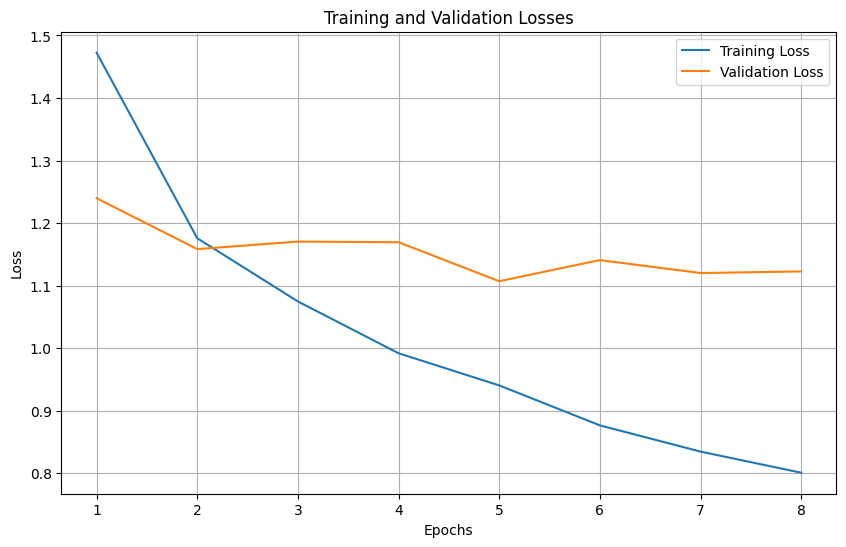

In [32]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Saving the Model

In [25]:
!pwd

/home/sunil/Hate_Speech_Project/LLAMA2_Model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
# Assuming `model_directory` is defined and points to where you want to save your model, tokenizer, and config
from transformers import AutoConfig
import os

# Define the directory where you want to save your model and tokenizer
model_directory = "/home/sunil/Hate_Speech_Project/LLAMA2_Model/llama_binary_finetuned_model"

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# First, save your trained model and tokenizer
llama_model.save_pretrained(model_directory)
llama_tokenizer.save_pretrained(model_directory)

# Then, save the configuration
config = AutoConfig.from_pretrained("meta-llama/Llama-2-7b-hf", num_labels=5) # Adjust as necessary
config.save_pretrained(model_directory)

print(f"Model, tokenizer, and configuration saved to {model_directory}")

Model, tokenizer, and configuration saved to /home/sunil/Hate_Speech_Project/LLAMA2_Model/llama_binary_finetuned_model


## Loading the Model

In [34]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the directory where your saved model and tokenizer are
model_directory = "/home/sunil/Hate_Speech_Project/LLAMA2_Model/llama_binary_finetuned_model"

# Load the configuration and set the number of labels
config = AutoConfig.from_pretrained(model_directory, num_labels=5)

# Now, load the model with the updated configuration
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)

# Load the tokenizer as usual
#mistral_tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint, add_prefix_space=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory,add_prefix_space=True)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Evaluation on Validation datasets

In [35]:
%%time
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv
CPU times: user 2d 15h 33min 32s, sys: 52min 31s, total: 2d 16h 26min 4s
Wall time: 1h 9min 44s


In [36]:
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")
df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,3370,Zakhme dill dikhaye gey\nHaal e gham sunaye ge...,3,Neutral,2,2
1,4731,Always reassuring to know that as an ace perso...,3,Neutral,2,1
2,3283,"happy birthday to Rin Natsume, she’s a trans l...",1,Very_Positive,0,1
3,4991,William Gay in at free safety with the first-t...,3,Neutral,2,2
4,2146,seeing people say that being bi isn't real/doe...,3,Neutral,2,1


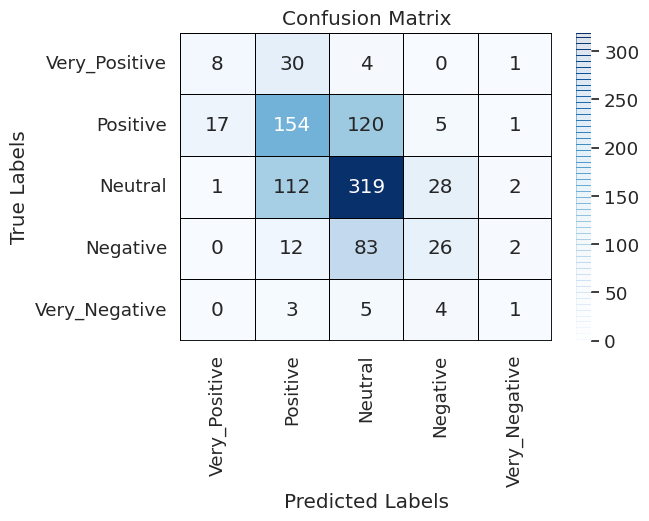

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.31      0.19      0.23        43
     Positive       0.50      0.52      0.51       297
      Neutral       0.60      0.69      0.64       462
     Negative       0.41      0.21      0.28       123
Very_Negative       0.14      0.08      0.10        13

     accuracy                           0.54       938
    macro avg       0.39      0.34      0.35       938
 weighted avg       0.52      0.54      0.53       938



## Model Evaluation on Test Datasets

In [39]:
%%time
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded
def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv
CPU times: user 3d 14h 28min 37s, sys: 20min 37s, total: 3d 14h 49min 14s
Wall time: 1h 32min 13s


In [40]:
output_df = pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv')
output_df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,4298,Being asexual in the month of june is very har...,2,Positive,1,2
1,2329,full fucking offense but cis people have no ri...,3,Neutral,2,2
2,537,"“if you're black, if you're white, if you're g...",1,Very_Positive,0,0
3,3218,It's a serious issue that i have to look for l...,2,Positive,1,2
4,644,"Have come out (again, still, constantly) to pe...",2,Positive,1,1


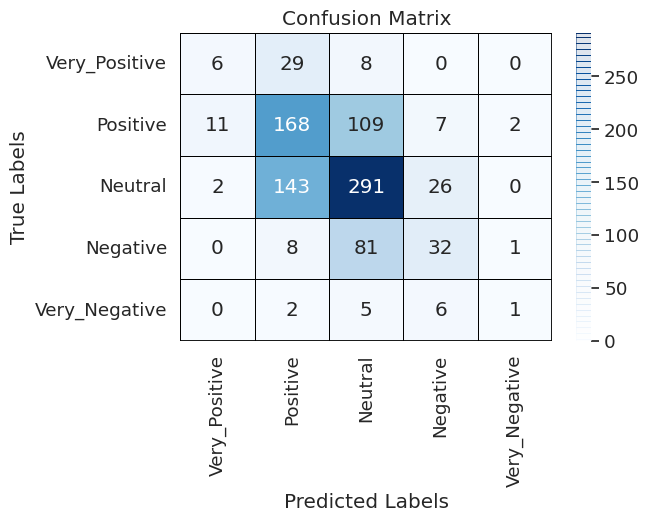

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")
#df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_2.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.32      0.14      0.19        43
     Positive       0.48      0.57      0.52       297
      Neutral       0.59      0.63      0.61       462
     Negative       0.45      0.26      0.33       122
Very_Negative       0.25      0.07      0.11        14

     accuracy                           0.53       938
    macro avg       0.42      0.33      0.35       938
 weighted avg       0.52      0.53      0.52       938



## General Inferencing

In [43]:
import torch

# Tokenize the input sentence
sentence = "Gay are bad people, and they don't deserve place in society."
tokenized_input = llama_tokenizer(sentence, truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Ensure the input tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenized_input = tokenized_input.to(device)

# Perform inference
with torch.no_grad():
    outputs = llama_model(**tokenized_input)

# Get predicted probabilities and class
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted Class:", predicted_class)

Predicted Class: 2


In [44]:
import torch

# Tokenize the input sentence
sentence = "I hate you, You are worst gay."
tokenized_input = llama_tokenizer(sentence, truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Ensure the input tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenized_input = tokenized_input.to(device)

# Perform inference
with torch.no_grad():
    outputs = llama_model(**tokenized_input)

# Get predicted probabilities and class
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted Class:", predicted_class)

Predicted Class: 2


In [45]:
import torch

# Tokenize the input sentence
sentence = "LGBTQ+ people are also human, Give respect to save humanity."
tokenized_input = llama_tokenizer(sentence, truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Ensure the input tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenized_input = tokenized_input.to(device)

# Perform inference
with torch.no_grad():
    outputs = llama_model(**tokenized_input)

# Get predicted probabilities and class
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted Class:", predicted_class)

Predicted Class: 1


In [46]:
import torch

# Tokenize the input sentence
sentence = "India is My Country"
tokenized_input = llama_tokenizer(sentence, truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Ensure the input tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenized_input = tokenized_input.to(device)

# Perform inference
with torch.no_grad():
    outputs = llama_model(**tokenized_input)

# Get predicted probabilities and class
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print("Predicted Class:", predicted_class)

Predicted Class: 2
